<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/1D_CNN_asof_11FEB1252.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpaca_trade_api

     |████████████████████████████████| 45 kB 1.8 MB/s 
     |████████████████████████████████| 1.3 MB 8.8 MB/s 
     |████████████████████████████████| 636 kB 66.2 MB/s 
     |████████████████████████████████| 273 kB 48.3 MB/s 
     |████████████████████████████████| 103 kB 73.8 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 32.5 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3


Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [2]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

In [3]:
random_seed = 182
torch.manual_seed(random_seed)

In [4]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [5]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [68]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

from datetime import date

train_start = date(2017, 1, 1)
train_end = date(2020, 3, 29)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 400
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "CORN" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 0 # Number of days to off set the training data
train_raw, val_raw, test_raw, full_raw, offset_raw, complete_raw, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
    Time Frame: 0930-1930
    Backfilling NaNs
    Adjusting Volume to Zero if no Trading data is present
      - Assumption is that there were no trades duing that time 

  We will build over lapping arrays by 30 min to give ourselfs more
  oppurtunities to predict during a given trading day 
  """
  
  df = df.between_time('07:29','17:29') # intial sorting of data

  TZ = 'US/Eastern' # define the correct timezone

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  # build blank index that has ever 5 min interval represented
  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time').set_index("Time").between_time('09:29','17:29')

  # create the close array by back filling NA, to represent no change in close
  closeset_list = []
  prev_c = None

  for c in filtered_df["Close"]:

    if prev_c == None:
      if math.isnan(c):
        prev_c = 0
        closeset_list.append(0)
      else:
        prev_c = c
        closeset_list.append(c)
    
    elif prev_c != None:
      if c == prev_c:
        closeset_list.append(c)
      elif math.isnan(c):
        closeset_list.append(prev_c)
      else:
        closeset_list.append(c)
        prev_c = c
    
  filtered_df["Close"] = closeset_list

  # create the volume
  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v

  filtered_df["Volume"] = volumeset_list
  
  adjvolumeset_list = []
  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df  

Number of days of Training Data 1183
Number of days of Validation Data 400
Number of days of Holdout Test Data 284


In [69]:
train_raw[275:300]

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2017-01-11 13:35:00-05:00,2017-01-11 13:35:00-05:00,18.9885,18.9885,18.9885,18.9885,1003,18.988500
2017-01-11 13:40:00-05:00,2017-01-11 13:40:00-05:00,18.9600,18.9600,18.9600,18.9600,100,18.960000
2017-01-11 13:50:00-05:00,2017-01-11 13:50:00-05:00,19.0000,19.0000,19.0000,19.0000,2300,19.000000
2017-01-11 14:05:00-05:00,2017-01-11 14:05:00-05:00,19.0800,19.0800,19.0800,19.0800,300,19.080000
2017-01-11 14:10:00-05:00,2017-01-11 14:10:00-05:00,19.0835,19.0835,19.0835,19.0835,500,19.083500
2017-01-11 14:15:00-05:00,2017-01-11 14:15:00-05:00,19.0652,19.0652,19.0652,19.0652,1414,19.065200
2017-01-11 14:20:00-05:00,2017-01-11 14:20:00-05:00,19.0757,19.0860,19.0757,19.0860,1064,19.078256
2017-01-11 15:00:00-05:00,2017-01-11 15:00:00-05:00,19.0640,19.0640,19.0640,19.0640,500,19.064000
2017-01-11 15:05:00-05:00,2017-01-11 15:05:00-05:00,19.0800,19.0800,19.0600,19.0600,1621,19.061912


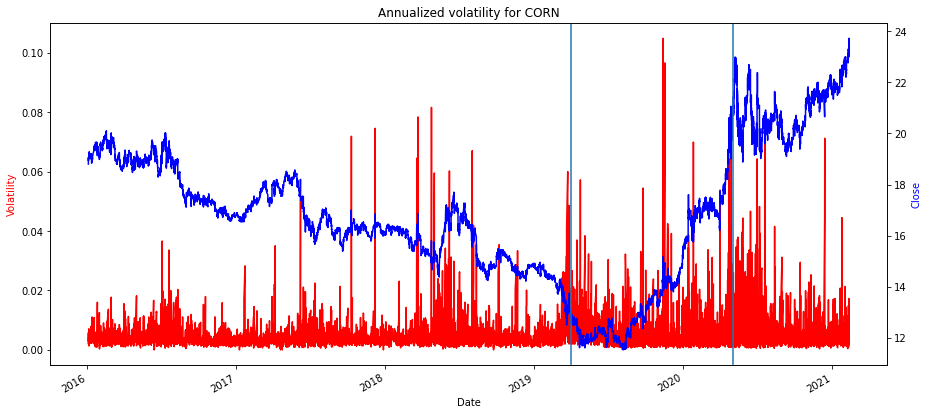

In [70]:
def buildTargets_VolOnly(full_df = full_raw, train_observations = train_raw.shape[0], 
                         val_observations = val_raw.shape[0], 
                         test_observations = test_raw.shape[0], 
                         alph = .55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full_raw.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
ax2.axvline(x=full_raw.index[train_raw.shape[0]])
ax2.axvline(x=full_raw.index[val_raw.shape[0]+train_raw.shape[0]])
plt.show()

In [71]:
train = timeFilterAndBackfill(train_raw)
val = timeFilterAndBackfill(val_raw)
test = timeFilterAndBackfill(test_raw)

train = train[train.index.dayofweek <= 4].copy()
val = val[val.index.dayofweek <= 4].copy()
test = test[test.index.dayofweek <= 4].copy()

train["Open"] = np.where((train["Volume"] == 0), train["Close"], train["Open"])
train["High"] = np.where((train["Volume"] == 0), train["Close"], train["High"])
train["Low"] = np.where((train["Volume"] == 0), train["Close"], train["Low"])

val["Open"] = np.where((val["Volume"] == 0), val["Close"], val["Open"])
val["High"] = np.where((val["Volume"] == 0), val["Close"], val["High"])
val["Low"] = np.where((val["Volume"] == 0), val["Close"], val["Low"])

test["Open"] = np.where((test["Volume"] == 0), test["Close"], test["Open"])
test["High"] = np.where((test["Volume"] == 0), test["Close"], test["High"])
test["Low"] = np.where((test["Volume"] == 0), test["Close"], test["Low"])

def strided_axis0(a, L, overlap=1):
    if L==overlap:
        raise Exception("Overlap arg must be smaller than length of windows")
    S = L - overlap
    nd0 = ((len(a)-L)//S)+1
    if nd0*S-S!=len(a)-L:
        warnings.warn("Not all elements were covered")
    m,n = a.shape
    s0,s1 = a.strides
    return np.lib.stride_tricks.as_strided(a, shape=(nd0,L,n), strides=(S*s0,s0,s1))

# OLDER CODE WITHOUT OVERLAP OF LABELING
# def blockshaped(arr, nrows, ncols):
#     """
#     Return an array of shape (n, nrows, ncols) where
#     n * nrows * ncols = arr.size

#     If arr is a 2D array, the returned array should look like n subblocks with
#     each subblock preserving the "physical" layout of arr.
#     """
#     h, w = arr.shape
#     assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
#     assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
#     return np.flip(np.rot90((arr.reshape(h//nrows, nrows, -1, ncols)
#                .swapaxes(1,2)
#                .reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)


def blockshaped(arr, nrows, ncols, overlapping_5min_intervals = 12):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"

    return np.flip(np.rot90((strided_axis0(arr, 24, overlap=overlapping_5min_intervals).reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)

train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()

X_train_pre_final = blockshaped(train_array, 24, 5, overlapping_5min_intervals = 12)
X_val_pre_final = blockshaped(val_array, 24, 5, overlapping_5min_intervals = 12)
X_test_pre_final = blockshaped(test_array, 24, 5, overlapping_5min_intervals = 12)

# X_train_pre_final = blockshaped(train_array, 24, 5)
# X_val_pre_final = blockshaped(val_array, 24, 5)
# X_test_pre_final = blockshaped(test_array, 24, 5)

In [72]:
X_train_pre_final[0]

array([[1.88000e+01, 1.88101e+01, 1.88100e+01, 1.88270e+01, 1.88856e+01,
        1.88544e+01, 1.88700e+01, 1.88599e+01, 1.88643e+01, 1.88500e+01,
        1.88500e+01, 1.88528e+01, 1.88300e+01, 1.88800e+01, 1.88761e+01,
        1.88900e+01, 1.89172e+01, 1.89100e+01, 1.89100e+01, 1.89300e+01,
        1.89500e+01, 1.90000e+01, 1.90200e+01, 1.89945e+01],
       [1.88000e+01, 1.88400e+01, 1.88100e+01, 1.88708e+01, 1.88856e+01,
        1.88544e+01, 1.88700e+01, 1.88599e+01, 1.88643e+01, 1.88500e+01,
        1.88500e+01, 1.88528e+01, 1.88600e+01, 1.88800e+01, 1.88761e+01,
        1.89100e+01, 1.89172e+01, 1.89100e+01, 1.89100e+01, 1.89300e+01,
        1.89500e+01, 1.90300e+01, 1.90200e+01, 1.89945e+01],
       [1.88000e+01, 1.88100e+01, 1.88100e+01, 1.88270e+01, 1.88544e+01,
        1.88544e+01, 1.88400e+01, 1.88599e+01, 1.88510e+01, 1.88500e+01,
        1.88500e+01, 1.88300e+01, 1.88300e+01, 1.88800e+01, 1.88761e+01,
        1.88900e+01, 1.89172e+01, 1.89000e+01, 1.89100e+01, 1.89300e+01,
  

In [73]:
# create target from OHLC and Volume Data
def buildTargets(obs_array,  
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()

  # print(len(volatility), len(target_close_df["Close"]))

  
  targets = [2] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift() >= (target_close_df.Close * (1 + alph * target_close_df["Volitility"])), 
           1, targets)
  
  targets = np.where(target_close_df.Close.shift() <= (target_close_df.Close * (1 - alph * target_close_df["Volitility"])), 
           0, targets)

  return targets

In [74]:
volity_val = 10
alph = .015
y_train_pre_final = buildTargets(X_train_pre_final, alph=alph,  volity_int = volity_val)
y_val_pre_final = buildTargets(X_val_pre_final, alph=alph, volity_int = volity_val)
y_test_pre_final = buildTargets(X_test_pre_final, alph=alph, volity_int = volity_val)

In [75]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

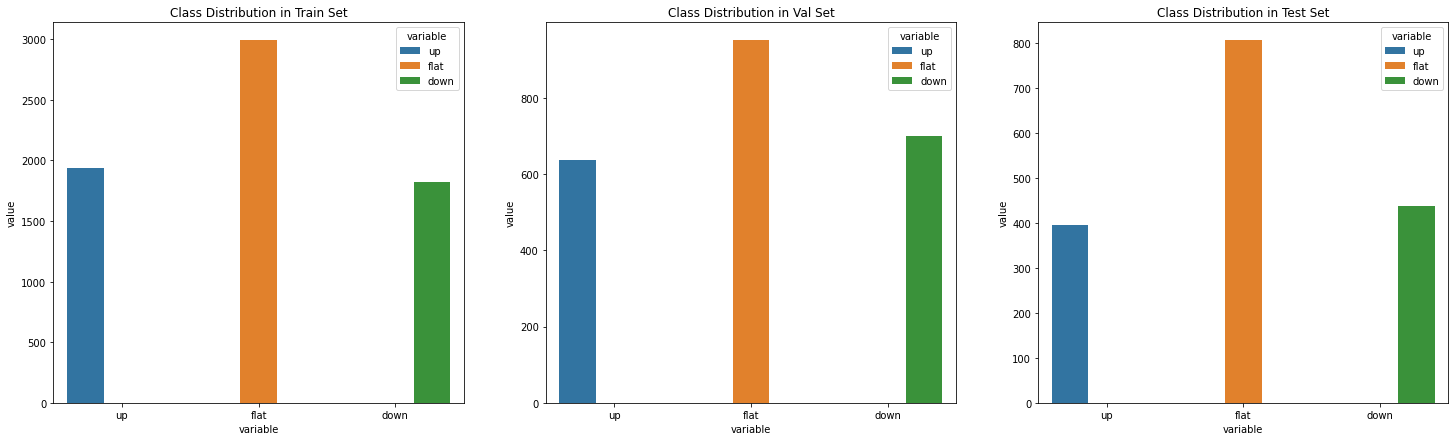

In [76]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [77]:
def createFinalData_RemoveLateAfternoonData(arr, labels):

  assert arr.shape[0] == len(labels), "X data do not match length of y labels"

  step_count = 0
  filtered_y_labels = []

  for i in range(arr.shape[0]):

    if i == 0:
      final_arr = arr[i]
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1

    elif i == 1:

      final_arr = np.stack((final_arr, arr[i]))
      filtered_y_labels.append(labels[i])
      step_count += 1

    elif step_count == 0: 
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
    
    elif (step_count) % 5 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 6 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 7 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count = 0
    
    else:
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
  
  return final_arr, filtered_y_labels

X_train, y_train = createFinalData_RemoveLateAfternoonData(X_train_pre_final, y_train_pre_final)
X_val, y_val = createFinalData_RemoveLateAfternoonData(X_val_pre_final, y_val_pre_final)
X_test, y_test = createFinalData_RemoveLateAfternoonData(X_test_pre_final, y_test_pre_final)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [78]:
# Check it arrays are made correctly
train[12:48]

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2017-01-03 10:30:00-05:00,18.8300,18.8600,18.8300,18.8600,375.0,18.850000
2017-01-03 10:35:00-05:00,18.8800,18.8800,18.8800,18.8800,325.0,18.880000
2017-01-03 10:40:00-05:00,18.8761,18.8761,18.8761,18.8761,200.0,18.876100
2017-01-03 10:45:00-05:00,18.8900,18.9100,18.8900,18.9100,576.0,18.893472
2017-01-03 10:50:00-05:00,18.9172,18.9172,18.9172,18.9172,1000.0,18.917200
2017-01-03 10:55:00-05:00,18.9100,18.9100,18.9000,18.9100,39966.0,18.909408
2017-01-03 11:00:00-05:00,18.9100,18.9100,18.9100,18.9100,0.0,0.000000
2017-01-03 11:05:00-05:00,18.9300,18.9300,18.9300,18.9300,2040.0,18.930000
2017-01-03 11:10:00-05:00,18.9500,18.9500,18.9500,18.9500,1000.0,18.950000


In [79]:
np.set_printoptions(threshold=200)
y_train_pre_final[0:24]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 2,
       2, 1])

In [80]:
######
# Code fro scaling at a later date
######

# from sklearn.preprocessing import MinMaxScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_val.shape[1]):
    scalers[i] = MinMaxScaler()
    X_val[:, i, :] = scalers[i].fit_transform(X_val[:, i, :]) 

for i in range(X_test.shape[1]):
    scalers[i] = MinMaxScaler()
    X_test[:, i, :] = scalers[i].fit_transform(X_test[:, i, :]) 
    

In [81]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

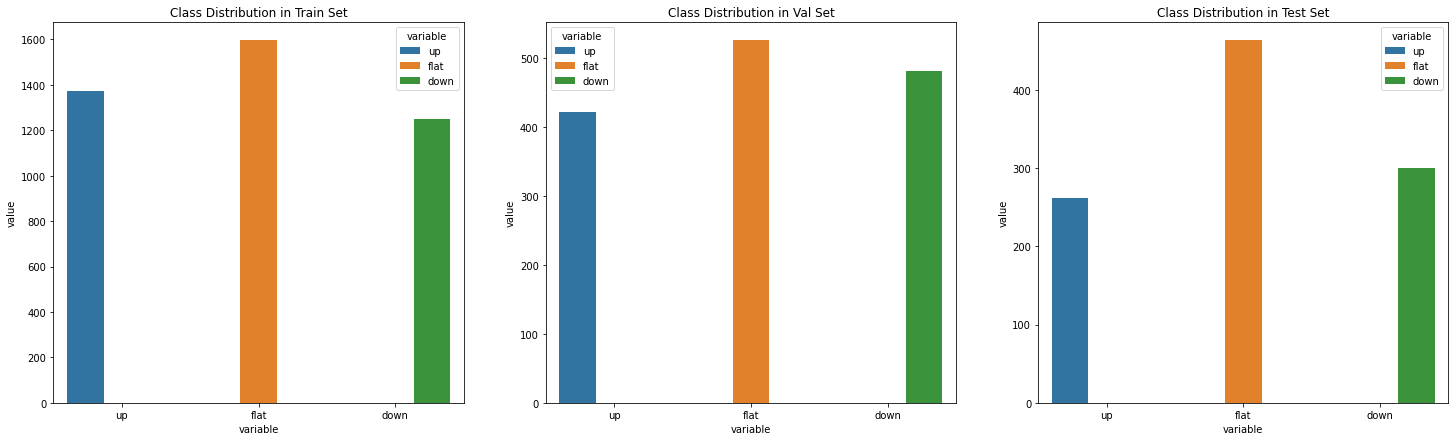

In [82]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [83]:
###### ONLY EXECUTE FOR 2D CNN #####

X_train = X_train.reshape(X_train.shape[0], 1,
                          X_train.shape[1], 
                          X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], 1,
                          X_val.shape[1], 
                          X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1,
                          X_test.shape[1], 
                          X_test.shape[2])

In [84]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (4220, 1, 5, 24), y Train Label Length (4220,)
X Val Length (1430, 1, 5, 24), y Val Label Length (1430,)
X Test Length (1025, 1, 5, 24), y Test Label Length (1025,)


# 2D CNN Build Model

In [85]:
trainset = TensorDataset(torch.from_numpy(X_train).float(), 
                         torch.from_numpy(y_train).long())
valset = TensorDataset(torch.from_numpy(X_val).float(), 
                        torch.from_numpy(y_val).long())
testset = TensorDataset(torch.from_numpy(X_test).float(), 
                        torch.from_numpy(y_test).long())

In [133]:
trainset

In [92]:
batch_size = 12

# train_data = []
# for i in range(len(X_train)):
#    train_data.append([X_train[i].astype('float'), y_train[i]])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
i1, l1 = next(iter(train_loader))
print(i1.shape)

# val_data = []
# for i in range(len(X_val)):
#    val_data.append([X_val[i].astype('float'), y_val[i]])

val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
i1, l1 = next(iter(val_loader))
print(i1.shape)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
i1, l1 = next(iter(test_loader))
print(i1.shape)

torch.Size([12, 1, 5, 24])
torch.Size([12, 1, 5, 24])
torch.Size([12, 1, 5, 24])


In [93]:
# Get next batch of training images
windows, labels = iter(train_loader).next()
print(windows)
windows = windows.numpy()

# plot the windows in the batch, along with the corresponding labels
for idx in range(batch_size):
    print(labels[idx])

tensor([[[[8.2873e-01, 8.2556e-01, 8.2579e-01,  ..., 8.4807e-01,
           8.5202e-01, 8.5319e-01],
          [8.2649e-01, 8.2967e-01, 8.2579e-01,  ..., 8.5221e-01,
           8.5202e-01, 8.5319e-01],
          [8.3446e-01, 8.2579e-01, 8.2674e-01,  ..., 8.4807e-01,
           8.5205e-01, 8.5439e-01],
          [8.2661e-01, 8.2555e-01, 8.2579e-01,  ..., 8.5083e-01,
           8.5205e-01, 8.5439e-01],
          [1.2028e-02, 6.0699e-04, 0.0000e+00,  ..., 8.8472e-02,
           0.0000e+00, 4.7923e-03]]],


        [[[8.3287e-01, 8.3516e-01, 8.3486e-01,  ..., 8.4999e-01,
           8.5045e-01, 8.5175e-01],
          [8.3476e-01, 8.3516e-01, 8.3486e-01,  ..., 8.4999e-01,
           8.5045e-01, 8.5175e-01],
          [8.3846e-01, 8.3539e-01, 8.3576e-01,  ..., 8.4669e-01,
           8.5048e-01, 8.5295e-01],
          [8.3487e-01, 8.3516e-01, 8.3486e-01,  ..., 8.4669e-01,
           8.5048e-01, 8.5295e-01],
          [4.9347e-03, 6.3636e-04, 4.7039e-03,  ..., 3.5626e-02,
           2.2000e-02,

In [95]:
# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}
# Store size of training and validation sets
dataset_sizes = {'train':len(trainset),'val':len(valset)}
# Get class names associated with labels
classes = [0,1,2]

In [121]:
class StockShiftClassification(nn.Module):
  def __init__(self):
    super(StockShiftClassification, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = (1,3), stride=1, padding = 1)
    self.pool1 = nn.MaxPool2d((1,4),4)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = (1,3), stride=1, padding = 1)
    self.pool2 = nn.MaxPool2d((1,3),3)  

    self.conv3 = nn.Conv2d(64, 128, kernel_size = (1,3), stride=1, padding = 1)
    self.pool3 = nn.MaxPool2d((1,2),2)

    self.fc1 = nn.Linear(256,1000) #calculate this
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 3)

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    #print(x.size(1))

    x = x.view(x.size(0), -1)

    

    # Linear layer
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    output = x#F.softmax(x, dim=1)

    return output


In [122]:
# Instantiate the model
net = StockShiftClassification().float()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(windows.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [12, 32, 7, 24]             128
         MaxPool2d-2             [12, 32, 2, 6]               0
            Conv2d-3             [12, 64, 4, 6]           6,208
         MaxPool2d-4             [12, 64, 2, 2]               0
            Conv2d-5            [12, 128, 4, 2]          24,704
         MaxPool2d-6            [12, 128, 2, 1]               0
            Linear-7                 [12, 1000]         257,000
            Linear-8                  [12, 500]         500,500
            Linear-9                    [12, 3]           1,503
Total params: 790,043
Trainable params: 790,043
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.95
Params size (MB): 3.01
Estimated Total Size (MB): 3.97
-------------------------------------------

In [142]:
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(y_train).long()
val_x = torch.from_numpy(X_val).float()
val_y = torch.from_numpy(y_val).long()

TypeError: ignored

In [123]:
# defining the model
model = net
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [140]:
from torch.autograd import Variable

def train(epoch, train_x, train_y, val_x, val_y):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [148]:
# defining the number of epochs
n_epochs = 100
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch, X_train, y_train, X_val, y_val)

Epoch :  1 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  17 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  19 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  21 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  23 	 loss : tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  25 	 loss : tensor(1.098

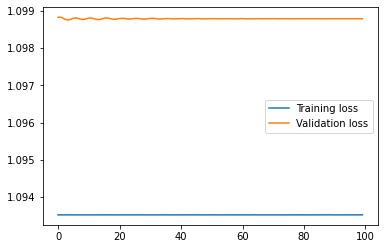

In [149]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [154]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

with torch.no_grad():
    output = model(X_val.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(y_val, predictions)

0.3678321678321678

In [125]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

NameError: ignored

In [98]:
def train_model(model, criterion, optimizer, train_loaders, device, num_epochs=50): #, scheduler=onecycle_scheduler):

    model = model.to(device) # Send model to GPU if available

    writer = SummaryWriter() # Instantiate TensorBoard

    iter_num = {'train':0,'val':0} # Track total number of iterations

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

                # Write loss for batch to TensorBoard
                writer.add_scalar("{} / batch loss".format(phase), loss.item(), iter_num[phase])

                # scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Write loss and accuracy for epoch to TensorBoard
            writer.add_scalar("{} / epoch loss".format(phase), epoch_loss, epoch)
            writer.add_scalar("{} / epoch accuracy".format(phase), epoch_acc, epoch)

    writer.close()
    
    return

In [30]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
weights = torch.tensor([1.75, 2.25, 1.]).to(device)
criterion_weighted = nn.CrossEntropyLoss(weight=weights)

criterion = nn.CrossEntropyLoss()

# Define optimizer
#optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00001)


n_epochs= 10 # For demo purposes.  Use epochs>100 for actual training

# onecycle_scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
#                                         max_lr=0.01,
#                                         base_momentum = 0.8,
#                                         steps_per_epoch=len(train_loader),
#                                         epochs=n_epochs)



train_model(net, criterion, optimizer, dataloaders, device, num_epochs=n_epochs) #, scheduler=onecycle_scheduler)

Epoch 0/99
----------
train Loss: 1.3127 Acc: 0.3615
val Loss: 1.0994 Acc: 0.3935
Epoch 1/99
----------
train Loss: 1.1108 Acc: 0.3545
val Loss: 1.1011 Acc: 0.3169
Epoch 2/99
----------
train Loss: 1.1089 Acc: 0.3480
val Loss: 1.1050 Acc: 0.3169
Epoch 3/99
----------
train Loss: 1.1076 Acc: 0.3501
val Loss: 1.1064 Acc: 0.3169
Epoch 4/99
----------
train Loss: 1.1071 Acc: 0.3488
val Loss: 1.1095 Acc: 0.3169
Epoch 5/99
----------
train Loss: 1.1068 Acc: 0.3553
val Loss: 1.1105 Acc: 0.3169
Epoch 6/99
----------
train Loss: 1.1066 Acc: 0.3572
val Loss: 1.1110 Acc: 0.3169
Epoch 7/99
----------
train Loss: 1.1064 Acc: 0.3553
val Loss: 1.1112 Acc: 0.3169
Epoch 8/99
----------
train Loss: 1.1063 Acc: 0.3550
val Loss: 1.1117 Acc: 0.3169
Epoch 9/99
----------
train Loss: 1.1061 Acc: 0.3566
val Loss: 1.1117 Acc: 0.3169
Epoch 10/99
----------
train Loss: 1.1059 Acc: 0.3558
val Loss: 1.1119 Acc: 0.3169
Epoch 11/99
----------
train Loss: 1.1057 Acc: 0.3556
val Loss: 1.1121 Acc: 0.3169
Epoch 12/99
--

In [36]:
def test_model(model,val_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in val_loader:
 
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)

            #print(f'Logits: {logits}')

            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits, dim=0)
            # print(f'Probs after LogSoft: {probs}')

            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(2):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)

    
    return test_acc, recall_vals

In [37]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(net,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(2):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.288
For class 0, recall is 1.0
For class 1, recall is 0.0


In [ ]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 10 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [ ]:
y_flat_num = y_train[np.where(y_train == 2)].size
y_down_weight = round((y_flat_num / y_train[np.where(y_train == 0)].size) * 1.2, 3) 
y_up_weight = round((y_flat_num / y_train[np.where(y_train == 1)].size) * 1.5, 3)

print(y_down_weight, y_up_weight, 1)

0.0 0.0 1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)

criterion = nn.CrossEntropyLoss() 
# weights = torch.tensor([y_down_weight, y_up_weight, 1.]).to(device)
# criterion_weighted = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, weight_decay=0.00001)
epochs = 20

history = train(
    model = model,
    optimizer = optimizer,
    loss_fn = criterion,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=epochs,
    device=device)

train() called: model=StockShiftClassification, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  1.02, train acc:  0.68, val loss:  0.64, val acc:  0.66
Epoch  10/ 20, train loss:  0.61, train acc:  0.71, val loss:  0.65, val acc:  0.66
Epoch  20/ 20, train loss:  0.61, train acc:  0.71, val loss:  0.64, val acc:  0.66

Time total:     26.97 sec
Time per epoch:  1.35 sec


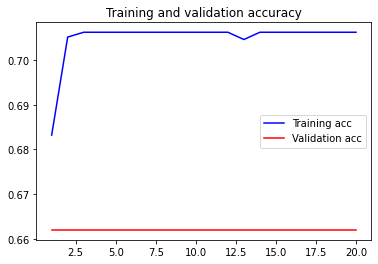

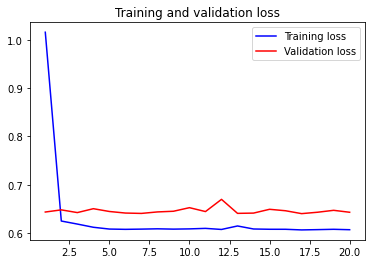

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
def test_model(model,val_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in val_loader:
 
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)

            #print(f'Logits: {logits}')

            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits)
            # print(f'Probs after LogSoft: {probs}')

            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(2):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)

    
    return test_acc, recall_vals
  

In [ ]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(model,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(2):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.662
For class 1, recall is 1.0
For class 0, recall is 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


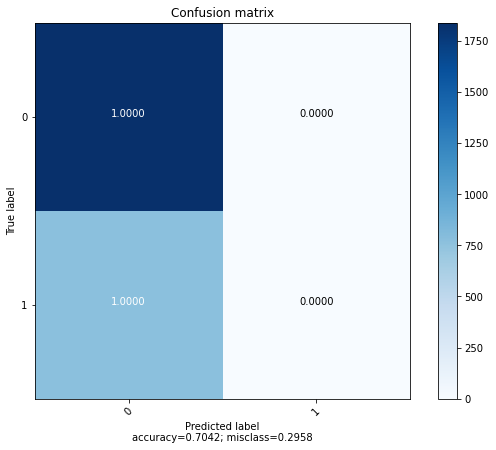

              precision    recall  f1-score   support

        down     0.7042    1.0000    0.8264      1838
          up     0.0000    0.0000    0.0000       772

    accuracy                         0.7042      2610
   macro avg     0.3521    0.5000    0.4132      2610
weighted avg     0.4959    0.7042    0.5820      2610



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        # print(inputs)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model.forward(inputs)
        #print(outputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
plot_confusion_matrix(conf_mat, [0,1])

from sklearn.metrics import precision_score

precision_score(lbllist.numpy(), predlist.numpy(), average='weighted')

from sklearn.metrics import classification_report

print(classification_report(lbllist.numpy(), predlist.numpy(), target_names=["down","up"], digits=4))